In [4]:
# Builds the minimum input control configuration (CF) from a given maximum matching
# Inputs are:
#    G, the network digraph
#    MM, another digraph consisting of the same nodes as G but only the edges contained in the maximum matching

# The procedure for this function is depicted schematically in Wang (2012) Fig. 2

import networkx as nx
import numpy as np

def BuildCF(G,MM):
    

    matching = MM.edges()
    zz = list(zip(*matching)) #split tuple list into "out" list and "in" list (just MM links)
    MMoutNodes = np.array(zz[0])
    MMinNodes = np.array(zz[1])
    
    allEdges = G.edges()
    zz = list(zip(*allEdges)) #split tuple list into "out" list and "in" list (all links)
    GoutNodes = np.array(zz[0])
    GinNodes = np.array(zz[1])
    
    # Find MDNS:
    
    MDNS = MM.nodes() #will be pruned down to Minimum Driver Node Set
    for lnk in matching: #if downstream end of edge is in MDNS, pop it
        try: 
            MDNS.remove(lnk[1])
        except ValueError:
            pass
    #print('Driver nodes: ', MDNS)
    
    # Find Stems:
    
    nStem = len(MDNS)
    
    
    stems = {} #dict of stems: key is index of MDNS, value is list of nodes
    stemEdges = {}
    
    for s in range(0,nStem):
        stems.setdefault(s, []) #initializes to empty list if value for s is undefined, does nothing if it's already defined
        stemEdges.setdefault(s, [])
        stems[s].append(MDNS[s])
        searchval = MDNS[s]
        while 1:
            searchval = stems[s][-1] #set to last item in the stem
            ii = np.where(MMoutNodes == searchval)[0] #returns indices of all MM edges which start from node searchval
            if len(ii) > 1:
                print('Stem appears to have a fork in it (problem!)')
                break
            elif len(ii) == 0: #in this case we've reached the end of the stem
                break
            else:
                if MMinNodes[ii[0]] in stems[s]:
                    print("Stem has looped back on itself: If you're reading this you need to code up a way to deal with it")
                    break
                else:
                    stems[s].append(MMinNodes[ii[0]]) #add next node of the stem to dict value
                    stemEdges[s].append([MMoutNodes[ii[0]],MMinNodes[ii[0]]])
        
    # Find Cycles:
        
    listCycles = list(nx.simple_cycles(MM))
    nCycle = len(listCycles)
    cycles = {} #dict of cycles
    cycleEdges = {}
    for c in range(0,nCycle):
        cycleEdges.setdefault(c, [])
        cycles[c] = listCycles[c]
        for i in range(len(cycles[c])):
            oN = cycles[c][i]
            iN = cycles[c][(i+1)%len(cycles[c])]
            cycleEdges[c].append([oN,iN])
    
    
    # Find Additional Links (AL)
    
    AL = {} #AL dict, keys are stem indices and values are edge tuples
    linkedCycles = {} #stores the indices of cycles linked to each stem
    for s in range(0,nStem):
        AL.setdefault(s, [])
        linkedCycles.setdefault(s, [])
        unlinkedCycles = list(cycles.keys())
        thisStem = stems[s]
        thisStem = thisStem[:-1] #cuts off the last node of the stem (per Wang: "any links from a top node of a stem to a cycle cannot be added to A")
        for n in thisStem:
            ii = np.where(GoutNodes == n)[0] #returns indices of all edges which start from node n
            if len(ii) == 0:
                break #end of the stem
            for l in ii: #loop through edges coming out of n
                outN = GoutNodes[l]
                inN = GinNodes[l]
                if (inN in thisStem) == 0: #skip the edge that's in the stem
                    for c in unlinkedCycles:
                        if inN in cycles[c]: #check if link goes to an as-yet unlinked cycle
                            thisEdge = tuple([outN,inN])
                            AL[s].append(thisEdge)
                            unlinkedCycles.remove(c)
                            linkedCycles[s].append(c)
            if len(unlinkedCycles) == 0:
                break
                
    cacti = {}
    for s in range(0,nStem):
        cdg = nx.DiGraph()
        cdg.add_nodes_from(stems[s])
        cdg.add_edges_from(stemEdges[s])
        for c in linkedCycles[s]:
            cdg.add_nodes_from(cycles[c])
            cdg.add_edges_from(cycleEdges[c])
        cdg.add_edges_from(AL[s])
        cacti[s] = cdg        
                
#     print("Stems: ", stems)
#     print("Cycles: ", cycles)
#     print("Additional Links: ", AL)
#     print("Linked Cycles: ", linkedCycles)
#     print("Stem Edges: ", stemEdges)
#     print("Cycle Edges: ", cycleEdges)

    return cacti

In [47]:
def downstreamCactus(cacti, N):
    # arguments are dict of cacti and node index
    # returns nx digraph of downstream cactus
    # if the given node is part of a cycle, just that cycle is returned
    import networkx as nx
    downCact = nx.DiGraph()
    for nc in cacti:
        c = cacti[nc]
        if N not in c.nodes(): #check if N is in this cactus
            continue
        else:
            # check if this cactus is a single node
            if len(c.nodes()) == 1:
                downCact.add_nodes_from(c.nodes())
                return downCact
            # check if N is in a cycle:
            inCycle = 0
            listCycles = list(nx.simple_cycles(c))
            for cy in listCycles:
                if N in cy:
                    cyEdges = []
                    for i in range(len(cy)):
                        oN = cy[i]
                        iN = cy[(i+1)%len(cy)]
                        cyEdges.append([oN,iN])
                    downCact.add_nodes_from(cy)
                    downCact.add_edges_from(cyEdges)
                    inCycle = 1
                    break
            
            if inCycle == 1:
                return downCact
                
            # if N isn't in a cycle, it's in a stem:    
            downCact.add_node(N)
            zz = list(zip(*c.edges())) #split tuple list into "out" list and "in" list
            CoutNodes = np.array(zz[0])
            CinNodes = np.array(zz[1])
            searchvals = []
            searchvals.append(N)
            alreadySearched = []
            iIter = 0
            while 1:
                if iIter > 100:
                    print("Caught in infinite loop? >100 iterations")
                    break
                #print("This iteration: searchvals = ", searchvals, ", alreadySearched = ", alreadySearched)
                if len(searchvals) == 0:
                    break
                else:
                    ii = []
                    for sv in searchvals:
                        iia = list(np.where(CoutNodes == sv)[0])
                        #print(sv, " : ", iia)
                        ii.append(iia) #returns indices of all edges which start from node searchval
                        alreadySearched.append(sv)
                    ii = [item for sublist in ii for item in sublist] #flatten ii
                    searchvals = [] #clear and populate with next generation of nodes
                    for nEdge in ii:
                        if int(CinNodes[nEdge]) not in alreadySearched:
                            searchvals.append(CinNodes[nEdge])
                            downCact.add_node(CinNodes[nEdge])
                            downCact.add_edge(CoutNodes[nEdge],CinNodes[nEdge])
                iIter += 1
            return downCact
    
    raise ValueError("Node doesn't appear in any cactus!")
            
                    
                    

In [12]:
def drawCactus(G,C):
    # draw a cactus (G is full digraph, C is cactus graph)
    # draws cactus in red, rest of G in black
    import networkx as nx
    import matplotlib.pyplot as plt
    
    # Specify the edges you want here
    red_edges = C.edges()
    edge_colors = ['black' if not edge in red_edges else 'red'
                    for edge in G.edges()]
    black_edges = [edge for edge in G.edges() if edge not in red_edges]
    
    node_colors = ['black' if not n in C.nodes() else 'red' for n in G.nodes()]
            

    # Need to create a layout when doing
    # separate calls to draw nodes and edges
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color = node_colors)
    nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    plt.axis('off')
    plt.show()

Downstream of node  1 :


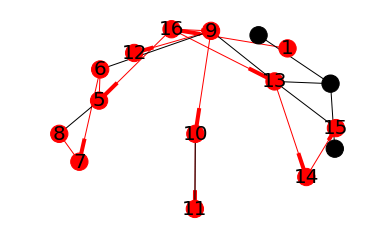

Downstream of node  2 :


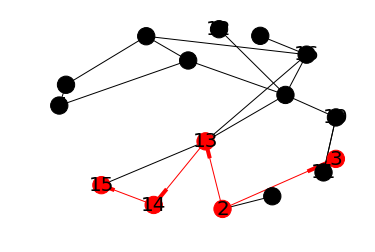

Downstream of node  3 :


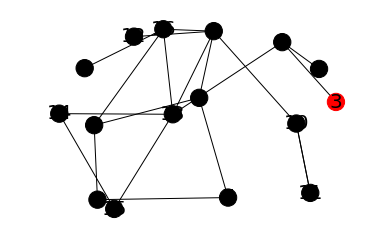

Downstream of node  4 :


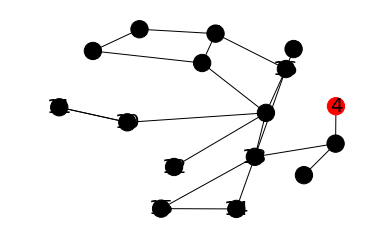

Downstream of node  5 :


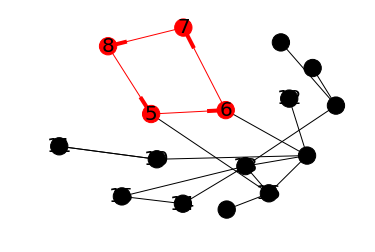

Downstream of node  6 :


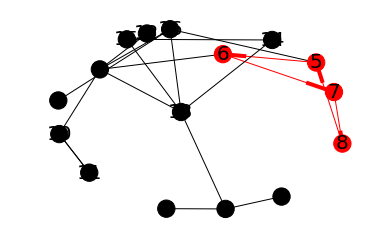

Downstream of node  7 :


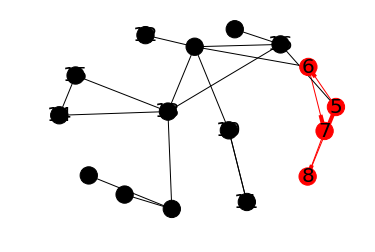

Downstream of node  8 :


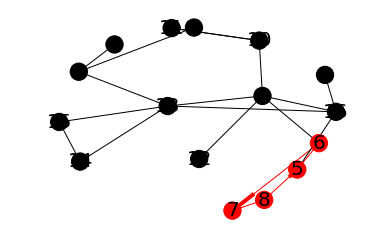

Downstream of node  9 :


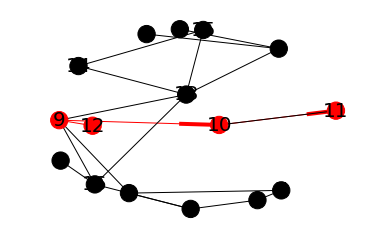

Downstream of node  10 :


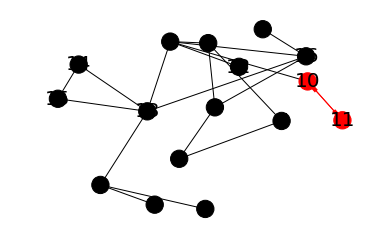

Downstream of node  11 :


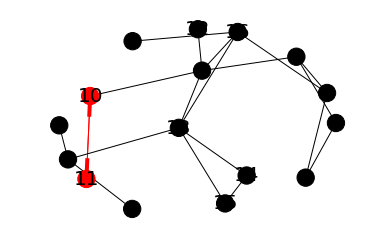

Downstream of node  12 :


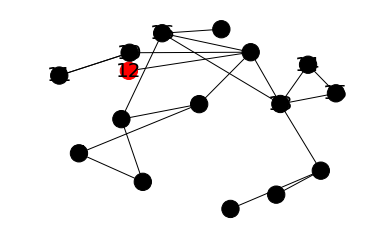

Downstream of node  13 :


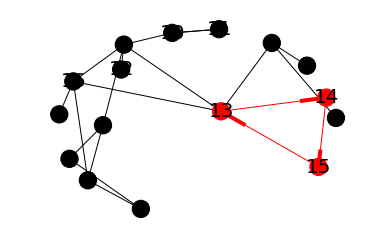

Downstream of node  14 :


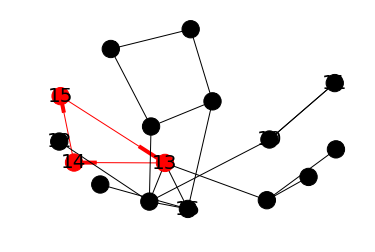

Downstream of node  15 :


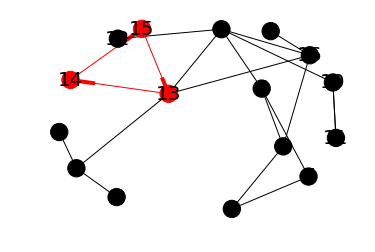

Downstream of node  16 :


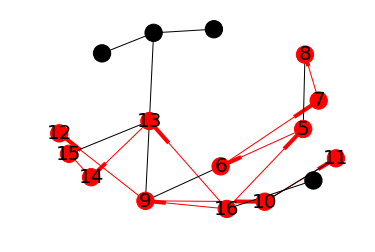

In [48]:
# # Test the function on the sample graph from Wang's paper (using the specific maximum matching depicted)
# import TestNetworks as TN
# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np

# G = TN.testNet(4)
# MM = nx.DiGraph()
# MM.add_nodes_from(range(1,17))
# MM.add_edges_from([(1,16),(16,9),(9,12),(5,6),(6,7),(7,8),(8,5),(2,3),(13,14),(14,15),(15,13),(10,11),(11,10)])

# cacti = BuildCF(G,MM)
# # for j in range(len(cacti)):
# #     print("Cactus ", j, ":")
# #     drawCactus(G,cacti[j])

# for n in G.nodes():
#     dsc = downstreamCactus(cacti,n)
#     print("Downstream of node ", n, ":")
#     drawCactus(G,dsc)
